In [1]:
import trimesh
from meshplot import plot

In [2]:
mesh = trimesh.load_mesh('./model_manifold.obj')

In [3]:
import igl

In [4]:
_,v_,f_,_,_ = igl.decimate(mesh.vertices,mesh.faces, 1500)


In [34]:
mesh = trimesh.Trimesh(v_,f_)

In [35]:
mesh.vertices.shape

(728, 3)

In [6]:
plot(mesh.vertices, mesh.faces)

/home/thor/anaconda3/envs/iglenv/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/thor/anaconda3/envs/iglenv/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0028013…

In [7]:
import numpy as np

In [22]:
def unordered_to_triangles(points):
    triangles = [[points[0], points[1], points[2]], [points[0], points[1],points[3]],[points[0], points[1], points[2]], [points[1], points[2],points[3]]]
    return np.array(triangles)
def unordered_to_triangles(points):
    triangles = [[points[0], points[2], points[3]], [points[1], points[2], points[3]]]
    return np.array(triangles)

In [63]:
def split_mesh(mesh, plane_normal=None, plane_origin=None):
    """
    Splits mesh by intersection with a plane, 
    returns closed mesh for positive and negative side of plane 
    """
#     plane_normal = (plane_normal)
#     plane_normal = plane_normal
#     plane_origin = plane_origin
    done = False
    while not done:
        if plane_normal is  None and plane_origin is  None:
#             plane_normal_ = np.random.randn(3)
#             plane_normal_ /= np.linalg.norm(plane_normal_)
# #             plane_origin_ = np.random.randn(3)
            plane_origin_ = np.mean(mesh.vertices, 0)
            idx1 = random.randint(0, mesh.vertices.shape[0]-1)
            idx2 = random.randint(0, mesh.vertices.shape[0]-1)
            v1 = mesh.vertices[idx1]
            v2 = mesh.vertices[idx2]
            v_1 = (v1 - v2)/ np.linalg.norm(v1 - v2)
            idx1 = random.randint(0, mesh.vertices.shape[0]-1)
            idx2 = random.randint(0, mesh.vertices.shape[0]-1)
            v1 = mesh.vertices[idx1]
            v2 = mesh.vertices[idx2]
            v_2 = (v1- v2 )/ np.linalg.norm(v1 - v2)
            plane_normal_ = np.cross(v_1, v_2)
#             plane_origin_ = mesh.vertices[random.randint(0, len(mesh.vertices)-1)]
        else:
            plane_normal_ = plane_normal
            plane_origin_ = plane_origin
        polyline, triangles_edge = trimesh.intersections.mesh_plane(mesh, 
                                                           plane_origin= plane_origin_, 
                                                           plane_normal= plane_normal_, 
                                                           return_faces=True)
        
#         print(polyline.shape)
        if polyline.shape[0]>0:
            print(plane_normal_, plane_origin_)
            print(polyline.shape)
            done = True
            break
        elif plane_normal is not None and plane_origin is not None and len(polyline)==0:
            print('Plane does not pass')
            print(plane_normal_, plane_origin_)
         
                                                                        
            return None, None
        
    print('found')
    plane_normal = plane_normal_
    plane_origin = plane_origin_
    
    vertices_negative = []
    vertices_positive = []
    for vertex_id, vertex in enumerate(mesh.vertices):
        # TODO: add threshold
        signed_distance = np.dot(plane_normal, np.subtract(vertex, plane_origin))
        if signed_distance < 0:
            vertices_negative.append(vertex_id)
        else:
            vertices_positive.append(vertex_id)
    
    triangles_negative = []
    triangles_positive = []
    # For each triangle check how many points on either side of the plane
    for triangle in mesh.faces:
        triangle_negative_check = [vertex_id in vertices_negative for vertex_id in triangle]
        # If all points on the negative side this triangle is not affected
        if all(triangle_negative_check):
            triangles_negative.append(np.array(mesh.vertices[triangle]))
        elif any(triangle_negative_check):
            # Get section line for this triangle on edge
            section = polyline[np.all(np.isin(mesh.faces[triangles_edge], np.array(triangle)), axis=1)][0]
            assert section.shape == (2,3)
            # If two points on negative side
            if sum(triangle_negative_check) == 2:
                vertex_1, vertex_2 = mesh.vertices[triangle[triangle_negative_check]]
                
                triangles_negative.extend(unordered_to_triangles([section[0], section[1], vertex_1, vertex_2]))
                vertex_3 = mesh.vertices[triangle[np.logical_not(triangle_negative_check)]]
                triangles_positive.append(np.vstack([section[0], section[1], vertex_3]))
            elif sum(triangle_negative_check) == 1:
                vertex_3 = mesh.vertices[triangle[triangle_negative_check]]
                triangles_negative.append(np.vstack([section[0], section[1], vertex_3]))
                vertex_1, vertex_2 = mesh.vertices[triangle[np.logical_not(triangle_negative_check)]]
#                 print(section[0], section[1], vertex_1, vertex_2)
                triangles_positive.extend(unordered_to_triangles([section[0], section[1], vertex_1, vertex_2]))
        # If all points on the positive side this triangle is not affected
        else:
            triangles_positive.append(np.array(mesh.vertices[triangle]))
            
    # Get triangulation of the split surface
    vertices_splitsurface = []
    for a, b in polyline:
        for vertex in [a,b]:
            if tuple(vertex) not in vertices_splitsurface:
                vertices_splitsurface.append(tuple(vertex))

    triangles_splitsurface = unordered_to_triangles(vertices_splitsurface)
    
    # Add triangles of split surface to both the positive and negative side
    triangles_negative.extend(triangles_splitsurface)
    triangles_positive.extend(triangles_splitsurface)
    
    print(plane_normal_, plane_origin_)
    
    return np.array(triangles_positive), np.array(triangles_negative), vertices_negative, vertices_positive

In [24]:
def get_verts_faces(triangles):
    v = np.unique(triangles.reshape(-1,3),axis=0)
    faces = []
    for triangle in triangles:
        tri_indices = []
        for vertex in triangle:
            for index, v_ in enumerate(v):
                if (v_ == vertex).all():
            
                    tri_indices.append(index)
        faces.append(tri_indices)
    return v, np.array(faces)

In [25]:
import random

In [51]:

num_patches = 5
   

patches = [mesh]

done = False
counter = 2
while  len(patches)!=num_patches:
    mesh = patches.pop()
    p_, n_ = split_mesh(mesh)
    print('split done')
    verts, faces  = get_verts_faces(p_)
    p_ = trimesh.Trimesh(verts, faces)
    verts, faces = get_verts_faces(n_)
    n_ = trimesh.Trimesh(verts, faces)

    patches.insert(0, p_)
    patches.insert(0, n_)

#     counter+=2
#     print(counter)
#     if counter >= num_patches:
#         break


[-0.04050905  0.35712332  0.32930299] [0.01493817 0.01165561 0.17769295]
(59, 2, 3)
found
[-0.04050905  0.35712332  0.32930299] [0.01493817 0.01165561 0.17769295]
split done
[ 0.09908701 -0.49525115  0.68354294] [0.01654909 0.01493896 0.20424688]
(24, 2, 3)
found
[ 0.09908701 -0.49525115  0.68354294] [0.01654909 0.01493896 0.20424688]
split done
[-0.80022451 -0.32478576 -0.49864388] [0.01644357 0.00733009 0.14845377]
(32, 2, 3)
found
[-0.80022451 -0.32478576 -0.49864388] [0.01644357 0.00733009 0.14845377]
split done
[-0.91862892  0.01577457  0.30331215] [ 0.00707613 -0.00336726  0.22983997]
(21, 2, 3)
found
[-0.91862892  0.01577457  0.30331215] [ 0.00707613 -0.00336726  0.22983997]
split done


In [52]:
print(len(patches))

5


In [53]:
mesh.vertices.shape

(139, 3)

In [54]:
import matplotlib.pyplot as plt

(93, 3)
(92, 3)
(121, 3)
(122, 3)
(114, 3)


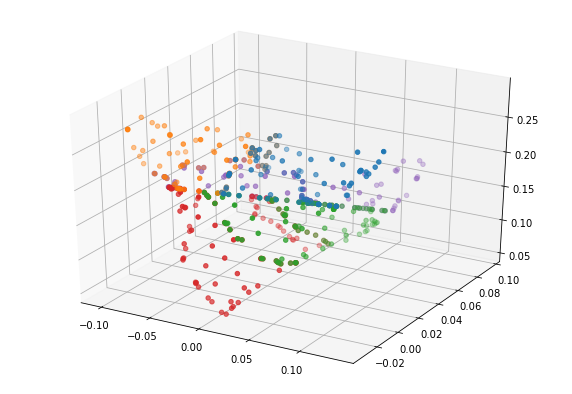

In [57]:
sum_ = 0
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for patch in patches:
    
# Creating plot
    print(patch.vertices.shape)
    ax.scatter3D(patch.vertices[:,0], patch.vertices[:,1], patch.vertices[:,2])
    

plt.show()

In [37]:
sum_

798

In [64]:
pos, neg, pos_points, neg_points = split_mesh(mesh)

[ 0.03445902 -0.06431377 -0.34679305] [ 0.00707613 -0.00336726  0.22983997]
(58, 2, 3)
found
[ 0.03445902 -0.06431377 -0.34679305] [ 0.00707613 -0.00336726  0.22983997]


In [66]:
pos.shape, np.array(pos_points).shape

((143, 3, 3), (67,))

In [67]:
neg.shape, np.array(neg_points).shape

((181, 3, 3), (72,))

In [62]:
mesh.vertices.shape

(139, 3)

In [80]:
def split_points(mesh_points):
    plane_origin_ = np.mean(mesh_points, 0)
    idx1 = random.randint(0, mesh_points.shape[0]-1)
    idx2 = random.randint(0, mesh_points.shape[0]-1)
    v1 = mesh_points[idx1]
    v2 = mesh_points[idx2]
    v_1 = (v1 - v2)/ np.linalg.norm(v1 - v2)
    idx1 = random.randint(0, mesh_points.shape[0]-1)
    idx2 = random.randint(0, mesh_points.shape[0]-1)
    v1 = mesh_points[idx1]
    v2 = mesh_points[idx2]
    v_2 = (v1- v2 )/ np.linalg.norm(v1 - v2)
    plane_normal_ = np.cross(v_1, v_2)
#             plane_origin_ = mesh.vertices[random.randint(0, len(mesh.vertices)-1)]
    pos_points = []
    neg_points = []
    for vertex in mesh_points:
        signed_distance =  np.dot(plane_normal_, np.subtract(vertex, plane_origin_))
        if signed_distance < 0:
            pos_points.append(vertex)
        else:
            neg_points.append(vertex)
    
    return np.array(pos_points), np.array(neg_points)

In [81]:
pos_points, neg_points = split_points(mesh.vertices)

In [82]:
pos_points.shape, neg_points.shape

((72, 3), (67, 3))

In [90]:
new_pos, new_neg = split_points(pos_points)

In [91]:
new_pos.shape, new_neg.shape

((31, 3), (41, 3))

In [98]:
mesh = trimesh.load_mesh('./model_manifold.obj')
_,v_,f_,_,_ = igl.decimate(mesh.vertices,mesh.faces, 1500)
mesh_in = trimesh.Trimesh(v_, f_)

In [99]:

mesh_in.vertices.shape

(728, 3)

In [101]:

num_patches = 5


patches = [mesh_in.vertices]


while  len(patches)!=num_patches:
    mesh = patches.pop()
    p_, n_ = split_points(mesh)
    print('split done')
#     verts, faces  = get_verts_faces(p_)
#     p_ = trimesh.Trimesh(verts, faces)
#     verts, faces = get_verts_faces(n_)
#     n_ = trimesh.Trimesh(verts, faces)

    patches.insert(0, p_)
    patches.insert(0, n_)
#     print(p_.shape, n_.shape)

split done
split done
split done
split done


In [86]:
print(len(patches))

5


(66, 3)
(91, 3)
(190, 3)
(178, 3)
(203, 3)


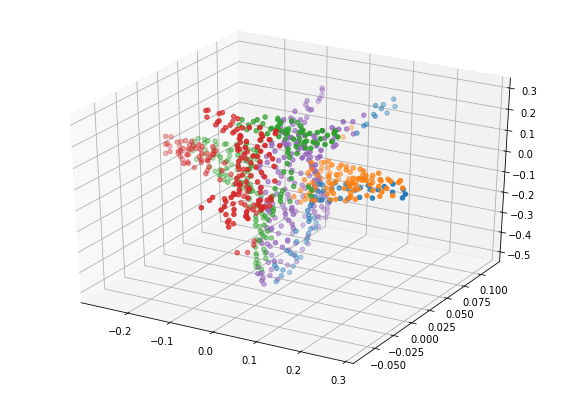

In [130]:
sum_ = 0
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for patch in patches:
    
# Creating plot
    print(patch.shape)
   
    ax.scatter3D(patch[:,0], patch[:,1], patch[:,2])
    

In [104]:
from sklearn.mixture import GaussianMixture

In [139]:
gmm_models = []
for patch in patches:
    model = GaussianMixture(n_components=3, random_state=0).fit(patch)
    print(model.means_.shape)
    gmm_models.append(model)
    

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)


In [144]:
gmm_models[0].sample(100)[0].shape

(100, 3)

In [141]:
vertices = []
for i in range(len(gmm_models)):
    vertices.append(gmm_models[i].sample(200)[0])

(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)


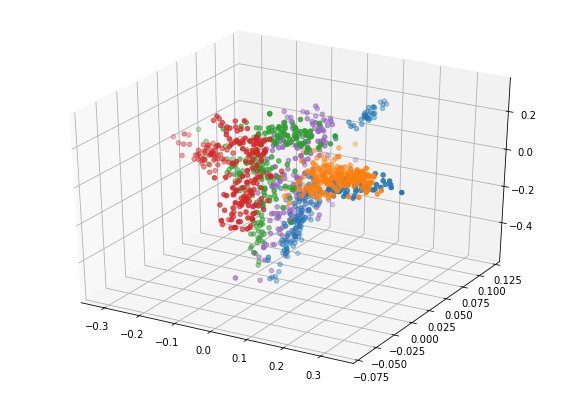

In [142]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for vertex_set in vertices:
    print(vertex_set.shape)
    ax.scatter3D(vertex_set[:,0], vertex_set[:,1], vertex_set[:,2])